In [1]:
!pip install tensorflow==2.3.0

Looking in indexes: http://192.168.0.94:8888/repository/pypi/simple
     |████████████████████████████████| 320.4 MB 120.6 MB/s eta 0:00:01     |█████████████████████████████▏  | 292.1 MB 120.6 MB/s eta 0:00:01
     |████████████████████████████████| 459 kB 90.8 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 40.7 MB/s eta 0:00:01
     |████████████████████████████████| 26.1 MB 82.5 MB/s eta 0:00:01
     |████████████████████████████████| 20.1 MB 65.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 98.0 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 84.5 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 99.3 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
   

In [1]:
%load_ext tensorboard

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import layers


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda,UpSampling2D,Conv2D,MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime


2023-09-07 11:48:55.078788: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/home/ma-user/anaconda3/envs/TensorFlow-2.1/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

In [3]:
from siamese_embeddings import *

In [4]:

# Model structure
def initialize_base_branch_vgg16_v2_1024():
    #this is the model used to make the embeddings
    #the input is 128x128x3
    input = Input(shape=(imsize,imsize,3), name="base_input")
    
    vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=input)
    vgg.trainable = False
    # flatten the max-pooling output of VGG
    flatten = vgg.output
    flatten = Flatten()(flatten)
    
    #embedding = Dense(2000,activation="relu")(flatten)
    #embedding = layers.Dropout(0.3, name="f_dropout")(embedding)
    embedding = Dense(2048,activation="relu")(flatten)
    embedding = layers.Dropout(0.3, name="s_dropout")(embedding)
    embedding = Dense(2048,activation="relu")(embedding)
    embedding = layers.Dropout(0.3, name="t_dropout")(embedding)
    embedding = Dense(1024, name="IMGembedding")(embedding)


    #convolutional feature extractor
    # input
    #Returning a Model, with input and outputs, not just a group of layers.
    return Model(inputs=input, outputs=embedding)

In [5]:
imsize = 224
base_model = initialize_base_branch_vgg16_latent_space()

2023-09-07 11:49:13.771694: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-09-07 11:49:13.854421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-07 11:49:13.856335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:0d.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-07 11:49:13.856364: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-09-07 11:49:13.858300: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-09-07 11:49:13.859907: I tensorflow/stream_executor/platfo

In [6]:
base_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [9]:
2**12

4096

## Exploring the Model Layers 

We have a model that use some layers of 
convolutional operations to extract spatial
information from the image. 
we can

In [9]:


#### Now plot filter outputs

#Define a new truncated model to only include the conv layers of interest
#conv_layer_index = [1, 3, 6, 8, 11, 13, 15]
conv_layer_index = [1, 3,6,9,12]  #TO define a shorter model
outputs = [base_model.layers[i].output for i in conv_layer_index]
model_short = Model(inputs=base_model.inputs, outputs=outputs)
print(model_short.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [10]:
#Input shape to the model is 224 x 224. SO resize input image to this shape.

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

img = load_img('jaguar.jpeg', target_size=(224, 224)) #VGG user 224 as input

# convert the image to an array
img = img_to_array(img)
# expand dimensions to match the shape of model input
img = np.expand_dims(img, axis=0)

# Generate feature output by predicting on the input image
feature_output = model_short.predict(img)

2023-09-06 11:03:53.087782: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2023-09-06 11:03:54.270343: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [ ]:
columns = 8
rows = 8
i2 = 0
for ftr in feature_output:
    print("One Layer")
    #pos = 1
    fig=plt.figure(figsize=(12, 12))
    for i in range(1, columns*rows +1):
        fig =plt.subplot(rows, columns, i)
        fig.set_xticks([])  #Turn off axis
        fig.set_yticks([])
        plt.imshow(ftr[0, :, :, i-1], cmap='gray')
        #pos += 1
    plt.savefig("layer_"+str(i2)+".png")
    plt.show()
    i2 += 1


In [8]:
#Input for the left part of the pair. We are going to pass training_pairs[:,0] to his layer.
input_a = Input(shape=(imsize,imsize,3), name='anchor_input')
#ATENTION!!! base_model is not an function, is model and we are adding our input layer.
vect_output_a = base_model(input_a)

#Input layer for the right part of the siamse model. Will receive: training_pairs[:,1]
input_p = Input(shape=(imsize,imsize,3), name='positive_input')
vect_output_p = base_model(input_p)


input_n = Input(shape=(imsize,imsize,3), name='negative_input')
vect_output_n = base_model(input_n)




#The lambda output layer calling the euclidenan distances, will return the difference between both vectors
output = Lambda(triplet_loss, name='output_layer')([vect_output_a, vect_output_p,vect_output_n])

#Our model have two inputs and one output. Each of the inputs contains the commom model.
model = Model([input_a, input_p,input_n], output)

In [9]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1024)         228891968   anchor_input[0][0]               
                                                                 positive_input[0][0]  

In [10]:
rms = RMSprop()
#We use the 'Custom' loss function. And we can pass the margin. I'ts one of the variables
#in the formula, and matain the balance between the value asigned when there arfe similarities or not.
#with a big value the dissimilarities have more wight than the similarities.
#you can try different values, I have the impression that we can increase the values and maybe improve
#a little bit the results.
#I choose to use an 1. Totally balanced.
embedding_dim = 2
LR = 0.0001
EPOCHS = 5
alpha = 0.2



In [ ]:
!pip install scikit-learn


In [11]:
from functions_siamese import *
from tensorflow.keras.optimizers import Adam


In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.000001),loss=identity_loss)

In [13]:
EPOCHS = 10
now = datetime.datetime.now()

checkpoint_filepath = 'models/checkpoint_1024_vgg16_latent_space'+datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='max',
    save_best_only=True)

In [14]:
log_dir = "logs/fit_1024_vgg16_latent_space/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


2023-09-07 11:49:49.149563: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2023-09-07 11:49:49.149643: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1391] Profiler found 1 GPUs
2023-09-07 11:49:49.150442: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcupti.so.10.1
2023-09-07 11:49:49.250852: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


In [15]:
train_generator = TripletDataGenerator(csv_file='csvs/big_triplets_no_bg.csv', output_size=(224, 224), shuffle=True, batch_size=64)


In [14]:
import PIL 

In [16]:

# Instantiate the data generator
# Fit the model
history = model.fit(train_generator, epochs=100, steps_per_epoch=20,callbacks=[model_checkpoint_callback,tensorboard_callback])
now = datetime.datetime.now()
#model.save_weights('model'+now.strftime("%Y-%m-%d_%H:%M:%S")+'.hdf5')


Epoch 1/100


2023-09-07 11:50:10.379917: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-09-07 11:50:10.720921: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


 1/20 [>.............................] - ETA: 0s - loss: 8850.0938

2023-09-07 11:50:14.356973: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2023-09-07 11:50:14.359118: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 2/20 [==>...........................] - ETA: 3s - loss: 7836.8765

2023-09-07 11:50:14.625818: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-09-07 11:50:14.637975: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/fit_1024_vgg16_latent_space/20230907-114949/train/plugins/profile/2023_09_07_11_50_14
2023-09-07 11:50:14.643500: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/fit_1024_vgg16_latent_space/20230907-114949/train/plugins/profile/2023_09_07_11_50_14/notebook-2589b5e6-3114-42ae-978c-b0dbae0dbf96.trace.json.gz
2023-09-07 11:50:14.656036: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/fit_1024_vgg16_latent_space/20230907-114949/train/plugins/profile/2023_09_07_11_50_14
2023-09-07 11:50:14.663397: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to logs/fit_1024_vgg

20/20 [==============================] - 30s 1s/step - loss: 7051.8804
Epoch 2/100
20/20 [==============================] - 20s 999ms/step - loss: 4434.1099
Epoch 3/100
20/20 [==============================] - 20s 998ms/step - loss: 3248.4307
Epoch 4/100
20/20 [==============================] - 20s 1000ms/step - loss: 2630.7361
Epoch 5/100
20/20 [==============================] - 20s 997ms/step - loss: 2028.1049
Epoch 6/100
20/20 [==============================] - 20s 1s/step - loss: 1492.0603
Epoch 7/100
20/20 [==============================] - 20s 992ms/step - loss: 1170.6682
Epoch 8/100
20/20 [==============================] - 20s 1s/step - loss: 1002.9670
Epoch 9/100
20/20 [==============================] - 20s 1s/step - loss: 851.2654
Epoch 10/100
20/20 [==============================] - 20s 1s/step - loss: 712.1890
Epoch 11/100
20/20 [==============================] - 20s 994ms/step - loss: 638.0031
Epoch 12/100
20/20 [==============================] - 20s 997ms/step - loss: 526.

In [17]:
now = datetime.datetime.now()
model.save_weights('models/model_1024_vgg16_latent_space'+now.strftime("%Y-%m-%d_%H:%M:%S")+'.hdf5')


In [21]:
convolutional_layers = model.layers[:] 

In [22]:
convolutional_layers

In [23]:
# Assuming model is your compiled Siamese network model
convolutional_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]


In [24]:
convolutional_layers

[]

In [25]:
from tensorflow.keras.models import Model

def get_convolutional_layers(model):
    convolutional_layers = []

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            convolutional_layers.append(layer)
        elif isinstance(layer, Model):  # Handle functional sub-models
            convolutional_layers.extend(get_convolutional_layers(layer))

    return convolutional_layers

convolutional_layers = get_convolutional_layers(model)

In [26]:
convolutional_layers

In [27]:
import pickle


In [37]:
len(convolutional_weights)

5

In [34]:
# Extract and save the weights of the convolutional layers
convolutional_weights = []
for layer in convolutional_layers:
    convolutional_weights.append(layer.get_weights())

# Save the convolutional weights to a file
import pickle
with open("convolutional_weights.pkl", "wb") as f:
    pickle.dump(convolutional_weights, f)

In [46]:
# Load the saved convolutional weights
import pickle
with open("convolutional_weights.pkl", "rb") as f:
    loaded_convolutional_weights = pickle.load(f)

# Build the model with the loaded convolutional weights
loaded_base_model = initialize_base_branch_1024_v2_vector_load()

for layer, weights in zip(loaded_base_model.layers, loaded_convolutional_weights):
    if weights:  # Check if weights exist for the layer
        layer.set_weights(weights)

# Now you can apply Grad-CAM using the loaded model
# Follow the Grad-CAM steps I mentioned earlier using loaded_base_model



NameError: name 'initialize_base_branch_1024_v2_vector_load' is not defined

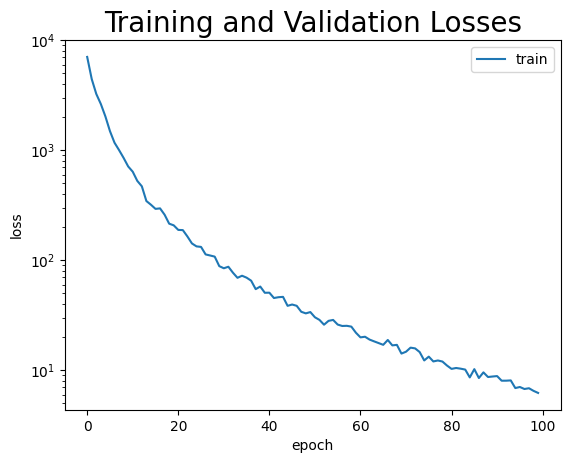

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

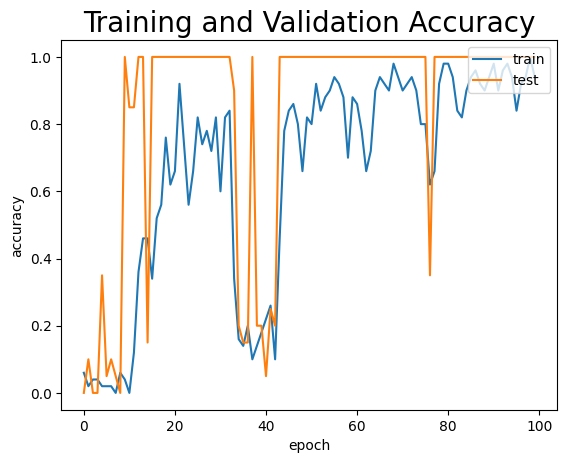

In [25]:
# summarize history for loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy',size = 20)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [26]:
# Using the newly trained model compute the embeddings
# for a number images
A = Input((imsize,imsize,3))
base_model = initialize_base_branch()
m = base_model(A)
trained_model = Model(inputs=A,outputs=m)
trained_model.load_weights("model.hdf5")

AttributeError: 'str' object has no attribute 'decode'